In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../../")
os.getcwd()

'/home/mwirth/projects/sound-seperation'

In [3]:
from datasets import load_dataset_builder
from datasets import load_dataset
import tensorflow_hub as hub
import pandas as pd
import torch
from src.modules.models.tdcnn import TDConvNetpp, WaveformEncoder, WaveformDecoder
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from src.datamodules.components.normalization import NormalizePeak

2024-09-23 14:12:56.053141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 14:12:56.053177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 14:12:56.054097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 14:12:56.059572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 14:12:56.654964: W tensorflow/compiler/tf2

In [4]:
builder = load_dataset_builder("DBD-research-group/BirdSet", "XCL")
hsn = load_dataset_builder("DBD-research-group/BirdSet", "HSN")
#idx = [builder.info.features["ebird_code"].str2int(name) for name in hsn.info.features["ebird_code"].names] # idx for 

In [5]:
encoder = WaveformEncoder(256, 256)
decoder = WaveformDecoder(256, 256)
normalize = NormalizePeak(0.2)
model = TDConvNetpp(in_chan=256, n_src=4, n_repeats=4, encoder=encoder, decoder=decoder)

In [6]:
checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch007-XCL-loss_valid-10.6065-metric_valid10.6050.ckpt"
checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch059-XCM-sisdr-loss_valid-11.4109-metric_valid11.4107.ckpt"
#checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch049-xcm-snr-loss_valid-11.6958-metric_valid10.5788.ckpt"
#checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch059-xcm_no_normal-loss_valid-10.4859-metric_valid10.4858.ckpt"
state_dict = torch.load(checkpoint, weights_only=False)
state_dict = {k[6:]:v for k,v in state_dict["state_dict"].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
perch = hub.load(
    'https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')
cs = pd.read_csv("data/perch/label_updated.csv")

idx = [cs[cs["ebird2021"] == i].index.values[0] for i in hsn.info.features["ebird_code"].names]

2024-09-23 14:13:03.636832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 14:13:03.638629: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-23 14:13:05.355361: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55971840 exceeds 10% of free system memory.


In [37]:
cs.iloc[idx].reset_index();

In [38]:
np.array(hsn.info.features["ebird_code"].names);

In [8]:
ds = load_dataset("DBD-research-group/BirdSet", "HSN", cache_dir="data/HSN")

In [10]:
data = ds["test_5s"][57]
print(data["ebird_code_multilabel"])
wave, sr = librosa.load(data["filepath"], sr=16000)
with torch.no_grad():
    wave = normalize(wave)
    masks, est_wave, weights = model(torch.tensor(wave).unsqueeze(0))
    est_wave = est_wave.squeeze(0)
print(weights)

[1]
tensor([[0.4342, 0.0015, 0.3062, 0.2580]])


In [11]:
est_wave1 = torch.vstack([torch.tensor(wave).unsqueeze(0), est_wave])
waves = []
for i in range(est_wave1.size(0)):
    w = est_wave1[i, :]
    w = librosa.resample(w.numpy(), orig_sr=16000, target_sr=32000)
    w = normalize(w)
    waves.append(w)
est_wave1 = np.stack(waves)

In [12]:
from torch.nn.functional import one_hot

In [ ]:
label = perch.infer_tf(est_wave1)["label"].numpy()[:,idx]
torch.sigmoid(torch.tensor(label))

In [25]:
t = one_hot(torch.tensor(data["ebird_code_multilabel"]), num_classes=len(idx)).expand_as(torch.tensor(label))

In [26]:
t

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [230]:
preds = []
est_wave1 = torch.vstack([torch.tensor(wave).unsqueeze(0), est_wave])
for i in range(est_wave1.size(0)):
    w = est_wave1[i,:]
    audio_mean = w.mean()
    std = w.std()
    w = librosa.resample(w.numpy(), orig_sr=16000, target_sr=32000)
    display(Audio(w, rate=32000, normalize=False))
    w = normalize(w)
    
    logits = perch.infer_tf(np.expand_dims(w, 0))
    logits = torch.tensor(logits["label"].numpy())[:,idx]
    p = torch.sigmoid(logits)
    pred = (p > 0.1).int()
    for ii in pred.nonzero():
        print(cs.iloc[idx[ii[-1]]].values[0], "\nconfidence:", p[*ii])
    print("Correct confidence", p[:,data["ebird_code_multilabel"]].flatten())
    print("Biggest pred:", cs.iloc[idx[p.numpy().argmax()]].values[0], p.max())
    print("Correct Label:", hsn.info.features["ebird_code"].int2str(data["ebird_code_multilabel"]))
    print("mean pred:", p.mean(), p.std())
    print("-"*10)

Correct confidence tensor([0.0157])
Biggest pred: whcspa tensor(0.0157)
Correct Label: ['whcspa']
mean pred: tensor(0.0015) tensor(0.0037)
----------


Correct confidence tensor([0.0002])
Biggest pred: yelwar tensor(0.0032)
Correct Label: ['whcspa']
mean pred: tensor(0.0003) tensor(0.0007)
----------


Correct confidence tensor([0.0003])
Biggest pred: yerwar tensor(0.0007)
Correct Label: ['whcspa']
mean pred: tensor(0.0002) tensor(0.0002)
----------


Correct confidence tensor([0.0007])
Biggest pred: mouchi tensor(0.0017)
Correct Label: ['whcspa']
mean pred: tensor(0.0003) tensor(0.0005)
----------


Correct confidence tensor([0.0032])
Biggest pred: mouchi tensor(0.0090)
Correct Label: ['whcspa']
mean pred: tensor(0.0008) tensor(0.0020)
----------


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 20))

for i in range(0, est_wave1.shape[0]):
    # Compute the spectrogram
    S = librosa.feature.melspectrogram(y=est_wave1[i,:].flatten().numpy(), sr=16000, n_mels=256)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Overlay the spectrograms with different tints
    img = librosa.display.specshow(S_db, sr=16000, ax=axes[i], x_axis='time', y_axis='mel', cmap="gray_r")
    

    axes[i].set_title(f"{i}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Frequency")

axes[0].set_title(f"Original")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Frequency")
fig.colorbar(img, ax=axes, format="%+2.0f dB")
#plt.tight_layout()
plt.show()

/tmp/ipykernel_1970006/1050914277.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i].plot((torch.tensor(est_wave[i])).flatten(), alpha=0.6, label="Separated")


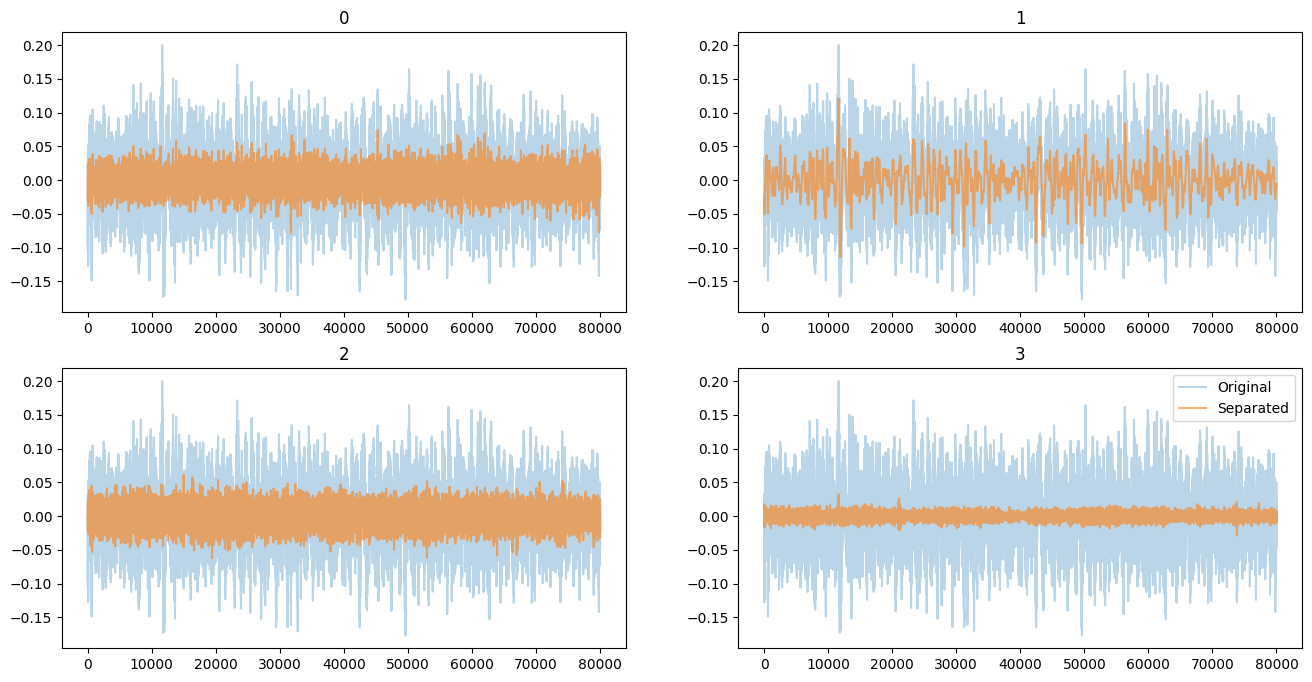

In [231]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()
for i in range(est_wave.shape[0]):
    axes[i].plot((torch.tensor(wave)).flatten(), alpha=0.3, label="Original")
    axes[i].plot((torch.tensor(est_wave[i])).flatten(), alpha=0.6, label="Separated")
    axes[i].set_title(f"{i}")
    #axes[i//2][i%2].vlines((data["start_time"] % 10)*16000, wave.flatten().min(), wave.flatten().max())
    #axes[i//2][i%2].vlines((data["end_time"] % 10)*16000, wave.flatten().min(), wave.flatten().max())
axes[-1].legend()